In [4]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
! mkdir ~/.kaggle

In [6]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shaleenkalsi","key":"8b1c1460c8f6114720e7efc43497fbbc"}'}

In [7]:
! cp kaggle.json ~/.kaggle/

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle datasets download -d blessondensil294/topic-modeling-for-research-articles

 79% 9.00M/11.4M [00:00<00:00, 70.7MB/s]
100% 11.4M/11.4M [00:00<00:00, 84.0MB/s]


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

Training data

In [11]:
!unzip "/content/topic-modeling-for-research-articles.zip" -d "/content/sample_data"

Archive:  /content/topic-modeling-for-research-articles.zip
  inflating: /content/sample_data/test.csv  
  inflating: /content/sample_data/train.csv  


In [12]:
train = pd.read_csv("/content/sample_data/train.csv")
train.head(2)

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0


In [13]:
train.drop("ID", axis=1, inplace=True)
x = train[["ABSTRACT"]]
y = train.drop(["TITLE", "ABSTRACT"], axis = 1)
y.head(2)

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,0,0,0,0,0
1,1,0,0,0,0,0


In [14]:
print(x[:5])
y.drop(["Quantitative Biology", "Quantitative Finance"], axis=1, inplace=True)
y.head(2)

                                            ABSTRACT
0    Predictive models allow subject-specific inf...
1    Rotation invariance and translation invarian...
2    We introduce and develop the notion of spher...
3    The stochastic Landau--Lifshitz--Gilbert (LL...
4    Fourier-transform infra-red (FTIR) spectra o...


,Computer Science,Physics,Mathematics,Statistics
0,1,0,0,0
1,1,0,0,0


In [15]:
test = pd.read_csv("/content/sample_data/test.csv")
test.head(2)

,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...


In [16]:
test.drop("ID", axis=1, inplace=True)

Create Corpus using ABSTRACTs from train and test data

In [17]:
corpus = pd.concat([x, test])["ABSTRACT"]
corpus.head(2)

0      Predictive models allow subject-specific inf...
1      Rotation invariance and translation invarian...
Name: ABSTRACT, dtype: object

In [18]:
from nltk.stem import WordNetLemmatizer
lemmer=WordNetLemmatizer()

In [61]:
nltk.download('wordnet')
nltk.download('omw-1.4')
def make_corpus(corpus):
  corpus=[' '.join([lemmer.lemmatize(word) for word in text.split(' ')])
          for text in corpus]
  corpus = [' '.join([word for word in text.split('\n')]) for text in corpus]
  corpus = [text[2:] for text in corpus]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [62]:
make_corpus(corpus)
print(corpus[:4])

0      Predictive models allow subject-specific inf...
1      Rotation invariance and translation invarian...
2      We introduce and develop the notion of spher...
3      The stochastic Landau--Lifshitz--Gilbert (LL...
Name: ABSTRACT, dtype: object


**BOW[Bag of words] = Tokenizing using CountVectorizer**

In [63]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [64]:
countVectorizer = CountVectorizer(stop_words="english")
bowVectors = countVectorizer.fit_transform(corpus)
bowVectors.shape

(29961, 66038)

In [65]:
vocab = np.array(countVectorizer.get_feature_names_out())

In [66]:
vocab.shape

(66038,)

In [67]:
print(vocab[66000:66010])

['zynq' 'zz' 'zz_2' 'zähle' 'zürich' 'école' 'également' 'éireann' 'élő'
 'émery']


**TF-IDF = tokenizing using TF-IDF Vectorizer** 

TF-IDF = Term frequency - Term frequency - inverse document frequency
Normalizes term counts based on ->


*   how often they appear in the document
*   how long is the document
*   how common/rare the term is







In [68]:
tfidfVectorizer = TfidfVectorizer(stop_words = 'english')
tfidfVectors = tfidfVectorizer.fit_transform(corpus)
tfidfVectors.shape

(29961, 66038)

In [69]:
print(len(x.ABSTRACT) + len(test.ABSTRACT), bowVectors.shape)

29961 (29961, 66038)


In [70]:
print(len(x.ABSTRACT) + len(test.ABSTRACT), tfidfVectors.shape)

29961 (29961, 66038)


Function to print topic words

In [29]:
num_top_words=10

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

**NMF - Non-negative matrix factorization**

V = WH

W = samples X topics

H = topics X topicwords



*   for NMF we need to specify the number of topics as hyperparameter [here; n_components = 4]
*   NMF gives non-unique result so random_seed needs to be set

In [71]:
from sklearn import decomposition

**BOW + NMF**

In [72]:
nmf = decomposition.NMF(n_components=4, random_state=1)
w = nmf.fit_transform(bowVectors)
h = nmf.components_
print(show_topics(h[:20]))

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


['learning network networks neural deep based training methods performance method', 'time problem results algorithm using method paper based number non', 'data analysis using method methods based approach used real information', 'model models based parameters using proposed dynamics process distribution state']


TF-IDF + NMF

In [79]:
w_ = nmf.fit_transform(tfidfVectors)
h_ = nmf.components_
print(show_topics(h_[:20]))

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


['algorithm data problem method model time proposed algorithms optimization based', 'mathbb mathcal prove group space finite equation groups functions solutions', 'spin quantum magnetic field energy phase temperature states model state', 'learning network networks neural deep training data model models tasks']


In [74]:
realtopics = y.idxmax(axis=1)

**Plotting TF-IDF + NMF as a seaborn heatmap**

In [75]:
import seaborn as sns
from matplotlib import style

In [80]:
nmftfidfmaintopics = np.argmax(w_, axis=1)
print(nmftfidfmaintopics)
w_ = pd.DataFrame(w_, columns=["Topic "+str(i) for i in range(1,5)])
print(w_)
w_["NMF-MainTopic"]=nmftfidfmaintopics
print(w_)

[0 3 1 ... 0 0 1]
        Topic 1   Topic 2   Topic 3   Topic 4
0      0.034821  0.000000  0.004473  0.023801
1      0.000000  0.001806  0.000000  0.052495
2      0.002376  0.026301  0.000000  0.000000
3      0.017609  0.036127  0.007094  0.000000
4      0.014543  0.000000  0.001582  0.025419
...         ...       ...       ...       ...
29956  0.020513  0.003068  0.002230  0.004819
29957  0.017055  0.005703  0.003476  0.000000
29958  0.015520  0.000000  0.008510  0.015293
29959  0.036903  0.000000  0.005210  0.007456
29960  0.000846  0.015888  0.000000  0.002565

[29961 rows x 4 columns]
        Topic 1   Topic 2   Topic 3   Topic 4  NMF-MainTopic
0      0.034821  0.000000  0.004473  0.023801              0
1      0.000000  0.001806  0.000000  0.052495              3
2      0.002376  0.026301  0.000000  0.000000              1
3      0.017609  0.036127  0.007094  0.000000              1
4      0.014543  0.000000  0.001582  0.025419              3
...         ...       ...       ...   

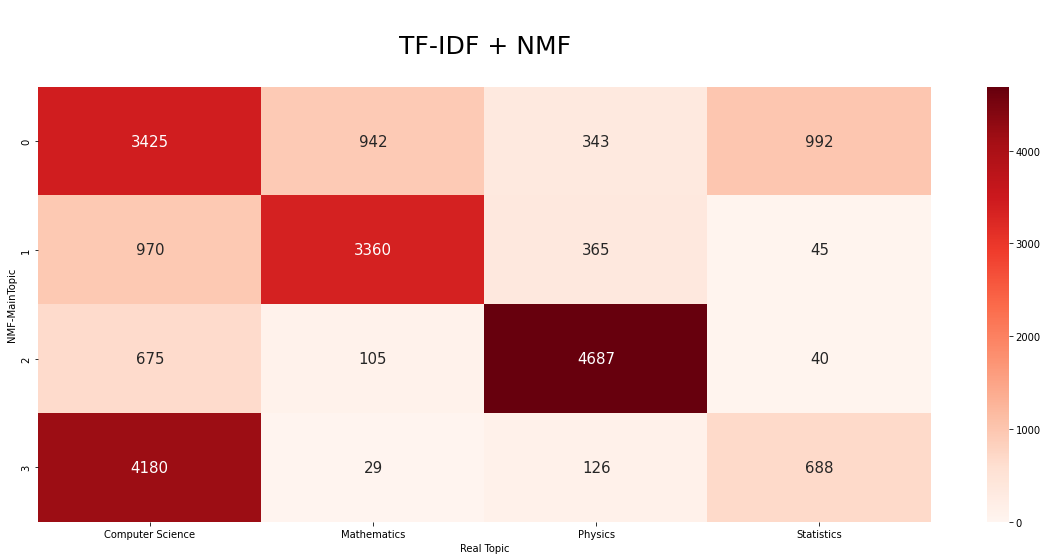

In [77]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,8))

sns.heatmap(pd.crosstab(w_["NMF-MainTopic"], realtopics), annot=True, fmt="d", annot_kws={"fontsize":15}, cmap="Reds", vmin=0)
axes.set_xlabel("Real Topic")
axes.set_title("\nTF-IDF + NMF\n", fontsize=25)

plt.show()